In [1]:
# imports
%load_ext autoreload
%autoreload 2
import torch.nn as nn
import torch
import re
from skimage import io
import sys
import numpy as np
from tqdm import tqdm 
import cv2
from PIL import Image
import torchvision
from torchvision import transforms as pth_transforms
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F
import os
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
#from RevenuePredictorViT import RevenuePredictorViT
!git clone https://github.com/facebookresearch/dino
sys.path.append('dino')
from dino import vision_transformer as vits

fatal: destination path 'dino' already exists and is not an empty directory.


In [2]:
import requests
import ast

In [3]:
# set to GPU if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
args_vit = {"arch": "vit_small",
 "patch_size": 8,
 "out_dim": 65536,
 "norm_last_layer": False,
 "warmup_teacher_temp": 0.04,
 "teacher_temp": 0.07,
 "warmup_teacher_temp_epochs": 30,
 "use_fp16": False,
 "weight_decay": 0.04,
 "weight_decay_end": 0.4,
 "clip_grad": 0,
 "batch_size_per_gpu": 64,
 "epochs": 800,
 "freeze_last_layer": 1,
 "lr": 0.0005,
 "warmup_epochs": 10,
 "min_lr": 1e-05,
 "global_crops_scale": [0.25,
 1.0],
 "local_crops_scale": [0.05,
 0.25],
 "local_crops_number": 10,
 "seed": 0,
 "num_workers": 10,
 "world_size": 16,
 "ngpus": 8,
 "nodes": 2,
 "optimizer": "adamw",
 "momentum_teacher": 0.996,
 "use_bn_in_head": False,
 "drop_path_rate": 0.1,
 "image_path": "./test_img/airbud.jpeg",
 "threshold": None,
 "image_size": (480, 480),
 "output_dir": "./"
}

args = {
   "avgpool": False,
    "last_n_blocks": 4, # TODO change this, this is what eval linear does
    "n_dnn_img_features": 16,
    "n_features": 25,
    "n_output_bins": 6,
}

path_prefix = './'

if 'COLAB_GPU' in os.environ:
    n_max = None
else:
    n_max = 50

Optional: for running on google colab

In [5]:
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
    path_prefix = '/content/drive/My Drive/'

# Load Data
Parameters
- csv
- number of entries to load (default all)
- path to images
- image transform function

Returns
- imgs
- features
- revenue (label?)

In [6]:
def img_rename(img_name):
    return re.sub(r'\W+', ' ', img_name).lower().strip().replace(' ', '+') + '.jpg'

def resize_poster(img, target_size):
    img_resized = resize(img, (target_size, int(img.shape[1] * (target_size / img.shape[0]))), anti_aliasing=True)
    pad_size_1 = (target_size - img_resized.shape[1]) // 2
    pad_size_2 = target_size - img_resized.shape[1] - pad_size_1
    padding = [(0, 0), (pad_size_1, pad_size_2), (0, 0)]
    if len(img_resized.shape) == 2: # gray scale image
        padding = [(0, 0), (pad_size_1, pad_size_2)]
    img_padded = np.pad(img_resized, padding, mode='constant', constant_values=0)
    return img_padded

def get_genre_dict():
    api_key_auth3 = 'fad9ac13c7b36b3e05f6b63be16e74f0'
    genre_dictionary = {}

    response = requests.get(f"https://api.themoviedb.org/3/genre/movie/list?api_key={api_key_auth3}&language=en-US")
    response = response.json()

    for genre in response['genres']:
        genre_dictionary[genre['id']] = genre['name']
        
    return genre_dictionary

def expand_genres_id(df):
    genre_dictionary = get_genre_dict()
    
    temp_df = df[['id', 'genre_ids']]
    temp_df['genre_ids'] = [ast.literal_eval(x) for x in temp_df['genre_ids']]
    temp_df['genres'] = [[genre_dictionary[v] for v in g_array] for g_array in temp_df['genre_ids']]

    exploded_df = temp_df[['id', 'genres']].explode(column='genres')
    exploded_df = pd.get_dummies(exploded_df, columns=['genres']).groupby('id', as_index=False).sum()

    merged_features = pd.merge(left=df
                    , right=exploded_df
                    , left_on='id'
                    , right_on='id')
    
    return merged_features.drop(columns=['genre_ids'])

def normalize_columns(df, cols):
    # Replace na with col mean
    df[cols] = df[cols].fillna(df[cols].mean())
    
    # Normalize
    c_min = df[cols].min()
    c_max = df[cols].max()
    df[cols]=(df[cols]-c_min)/(c_max-c_min)
    return df

class FeatureDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform, device, n_output_bins, n_max=None):
        # load csv data
        md_df = pd.read_csv(csv_path)
        
        # TODO TRANSFORM FEATURES FROM CSV SOMEHOW
        ## Genres
        md_df = expand_genres_id(md_df)
        
        ## Normalize and fill na
        to_normalize = ['popularity', 'vote_average', 'vote_count', 'production_budget', 'running_time']
        md_df = normalize_columns(md_df, to_normalize)
        
        
        # Groups numerical revenue, currently 6 bins
        num = range(n_output_bins)

        revenue_in = pd.qcut(md_df['domestic_box_office'] + md_df['international_box_office'], q=n_output_bins, labels=num)

        enc = OneHotEncoder().fit(np.array(revenue_in).reshape(-1,1))
        df = pd.DataFrame(enc.transform(np.array(revenue_in).reshape(-1,1)).toarray())
        df['combine'] = df.values.tolist()
        md_df['revenue_bin'] = df['combine']
        
        ## Drop a few columns 
        to_drop = ['adult', 'production_year', 'domestic_box_office', 'international_box_office'
                   , 'genre', 'original_language', 'id']
        md_df = md_df.drop(columns=to_drop)

        print(md_df.columns)
        
        movie_data = np.pad(md_df.to_numpy(), [(0, 0), (0, 1)], mode='constant', constant_values=np.nan)
        
        # restrict dataset for testing purposes
        if n_max:
            movie_data = movie_data[:n_max,:]
        
        # load image data
        self.movie_name_id = 3
        
        for i in tqdm(range(movie_data.shape[0])):
            img_path = img_dir + img_rename(movie_data[i,self.movie_name_id])
            try:
                img = transform(io.imread(img_path))
                if len(img.shape) < 3: # if greyscale, make rgb
                    img = np.stack((img, img, img), axis=-1) 
            except FileNotFoundError:
                pass
            movie_data[i, -1] = img

        self.movie_data = movie_data
        
    def __len__(self):
        return self.movie_data.shape[0]

    def __getitem__(self, idx):
        
        movie = self.movie_data[idx]
        
        revenue_id = 10
        
        img = torch.tensor(movie[-1]).to(torch.float32).swapaxes(0,2)
        label = torch.tensor(movie[-2]) # set this to whatever the revenue entry is
        features = np.delete(movie, (self.movie_name_id, -2, -1)) # remove image and revenue from non-image features
        features = torch.tensor(features.astype(float)).to(torch.float32) 
        
        # TODO idk how we're representing the dnn features so I'm just gonna make a dummy
        #features = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14]).to(torch.float32)
        #features = movie.drop(columns=to_drop)
        
        # MAKE THE SIZES WORK FOR VIT
        #img = img.swapaxes(0,2).unsqueeze(0).to(torch.float32)
        #features = features.unsqueeze(0)
        
        return img, features, label

In [7]:
def load_dataset(csv_name, poster_dir, device, batch_size):
    # TODO change transform function if desired
    img_size = 256
    transform = lambda x: resize_poster(x, img_size) 

    full_dataset = FeatureDataset(
        csv_path=path_prefix+csv_name,
        img_dir=path_prefix+poster_dir,
        transform=transform,
        device=device,
        n_max=n_max,
        n_output_bins=args['n_output_bins']
    )

    test_pct, val_pct = 0.3, 0.1
    test_size = int(len(full_dataset)*test_pct)
    dataset_size = len(full_dataset) - test_size
    val_size = int(dataset_size*val_pct)
    train_size = dataset_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_dl = DataLoader(val_dataset, batch_size, num_workers=0, pin_memory=True)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=True)

    return train_dataset, val_dataset, test_dataset, train_dl, val_dl, test_dl

# Generic Training Class

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    _, gts = torch.max(labels, dim=1)
    return torch.tensor(torch.sum(preds == gts).item() / len(preds))
    
class DNNBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, features, targets = batch
        
        img = img.to(device)
        features = features.to(device)
        targets = targets.to(device)
        
        out = self(img, features)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return loss, acc
    
    # validation step
    def validation_step(self, batch):
        img, features, targets = batch
        
        img = img.to(device)
        features = features.to(device)
        targets = targets.to(device)
        
        out = self(img, features)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, test_acc: {:.4f}".format(
                epoch, result["train_loss"], result["train_acc"], result["val_loss"], result["val_acc"], result["test_acc"]
            ))

        
class DNN_module(nn.Module):
    def __init__(self, input_dim, num_features, output_dim = 6, dropout = 0.6):

        unit_1 = 72
        unit_2 = 128
        unit_3 = 256


        super().__init__()
        self.input_layer = nn.Linear(input_dim, num_features)

        self.layers = nn.Sequential(
            nn.Linear(num_features, unit_1),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_1, unit_2),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_2, unit_3),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_3, unit_2),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout),

            nn.Linear(unit_2, unit_1),
            nn.ReLU(inplace=False),   
            nn.Dropout(p=dropout)
        )

        self.output_layer = nn.Sequential(
            nn.Linear(unit_1, output_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, features):
        x = self.input_layer(features)
        x = self.layers(x)
        x = self.output_layer(x)

        return x

In [9]:
class PreTrainedResnet18(DNNBase):
    def __init__(self, args, freeze_cnn=False):
        super().__init__()

        self.args = args
        
        self.cnn = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Linear(128, args['n_dnn_img_features'])
        )

        # freeze cnn
        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False
            for param in self.cnn.fc.parameters():
                param.requires_grad = True

        # TODO add DNN layers here
        self.dnn = DNN_module(args['n_dnn_img_features'] + args['n_features'] - 1
                              , 2 + args['n_features']
                              , args['n_output_bins'])
        
    def forward(self, img, features):
        # CNN output
        cnn_output = self.cnn(img)
        dnn_input = torch.cat((cnn_output, features), dim=1)
        output = self.dnn(dnn_input)
        return output

In [10]:
class RevenuePredictorViT(DNNBase):
    def __init__(self, args, args_vit, freeze_vit=False):
        super().__init__()

        student, teacher = self.load_pretrained_ViT(args_vit)

        self.vit_student = student
        self.vit_teacher = teacher

        self.vit_output_size = \
            args['last_n_blocks'] * self.vit_teacher.embed_dim

        self.vit2dnn = nn.Linear(self.vit_output_size, args['n_dnn_img_features'])

        # TODO set this to actual DNN
        #self.dnn = nn.Linear(args['n_dnn_img_features'] + args['n_features'], 1)
        self.dnn = DNN_module(args['n_dnn_img_features'] + args['n_features'] - 1
                              , 2 + args['n_features']
                              , args['n_output_bins'])

        self.args = args
        
        if freeze_vit:
            for param in self.vit_teacher.parameters():
                param.requires_grad = False
            for param in self.vit_student.parameters():
                param.requires_grad = False

    def forward(self, img, features, freeze_vit=True):
        # vit
        model = self.vit_teacher
        intermediate_output = model.get_intermediate_layers(img.swapaxes(-1,-2), self.args['last_n_blocks'])
        vit_output = torch.cat([x[:, 0] for x in intermediate_output], dim=-1)
        if self.args['avgpool']:
            vit_output = torch.cat((vit_output.unsqueeze(-1), torch.mean(intermediate_output[-1][:, 1:], dim=1).unsqueeze(-1)), dim=-1)
            vit_output = vit_output.reshape(vit_output.shape[0], -1)

        # vit2dnn
        fc_output = self.vit2dnn(vit_output)

        # dnn
        dnn_input = torch.cat((fc_output, features), dim=1) # concatenate img features with other movie details
        output = self.dnn(dnn_input)
        return output

    # create function to load pretrained model
    def load_pretrained_ViT(self, args):

        # initialize models
        student = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)
        teacher = vits.__dict__[args['arch']](patch_size=args['patch_size'], num_classes=0)

        # fetch pretrained models
        url = None
        if args['arch'] == "vit_small" and args['patch_size'] == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain_full_checkpoint.pth"
        elif args['arch'] == "vit_small" and args['patch_size'] == 8:
            url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain_full_checkpoint.pth"  # model used for visualizations in our paper
        elif args['arch'] == "vit_base" and args['patch_size'] == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain_full_checkpoint.pth"
        elif args['arch'] == "vit_base" and args['patch_size'] == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain_full_checkpoint.pth"

        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)

        state_dict_teacher = state_dict['teacher']
        # remove `module.` prefix
        state_dict_teacher = {k.replace("module.", ""): v for k, v in state_dict_teacher.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict_teacher = {k.replace("backbone.", ""): v for k, v in state_dict_teacher.items()}

        msg = teacher.load_state_dict(state_dict_teacher, strict=False)
        print('Pretrained weights found and loaded with msg: {}'.format(msg))

        state_dict_student = state_dict['student']
        # remove `module.` prefix
        state_dict_student = {k.replace("module.", ""): v for k, v in state_dict_student.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict_student = {k.replace("backbone.", ""): v for k, v in state_dict_student.items()}

        msg = student.load_state_dict(state_dict_student, strict=False)
        print('Pretrained weights found and loaded with msg: {}'.format(msg))

        # test this by running the eval thing
        return student, teacher

# Training Loop

In [11]:
def fit_one_cycle(model, device, train_loader, val_loader, test_loader, opt_func, train_args):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), train_args['lr'])
    
    for epoch in range(train_args['epochs']):
        # Training phase
        model.train()  
        train_losses = []
        train_accs = []

        for i, data in enumerate(train_loader, 0):
            loss, acc = model.training_step(data)

            train_losses.append(loss)
            train_accs.append(acc)
            
            # calculates gradients
            loss.backward()
            # perform gradient descent and modifies the weights
            optimizer.step()
            # clear grads
            optimizer.zero_grad()
            
        # Validation and Test phase
        result = evaluate(model, val_loader)
        test_acc = evaluate(model, test_loader)['val_acc']

        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['test_acc'] = test_acc
        model.epoch_end(epoch, result)

        history.append(result)
        
    return history

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def plot_history(history):
    train_acc = []
    val_acc = []
    test_acc = []
    train_loss = []
    time = list(range(len(history)))
    for h in history:
        train_acc.append(h['train_acc'])
        val_acc.append(h['val_acc'])
        test_acc.append(h['test_acc'])
        train_loss.append(h['train_loss'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(time, train_loss, c='red')
    ax1.set_title('Training Loss vs. Epochs')
    ax2.plot(time, train_acc, c='red', label='train_acc')
    ax2.plot(time, val_acc, c='blue', label='val_acc')
    ax2.plot(time, test_acc, c='green', label='test_acc')
    ax2.set_title('Accuracies vs. Epochs')
    ax2.legend()
    # fig.show()

## Train

In [12]:
if 'COLAB_GPU' in os.environ:
    train_args = {
        "batch_size": 32,
        "lr": 1e-3,
        "epochs": 100,
        "report_every": 10
    }
else:
    train_args = {
        "batch_size": 10,
        "lr": 1e-3,
        "epochs": 2,
        "report_every": 1
    }

### Load dataset

In [13]:
train_dataset, val_dataset, test_dataset, \
    train_dl, val_dl, test_dl = load_dataset('MovieDataEnhanced.zip', 'poster_img/', device, train_args['batch_size'])

/var/folders/82/0zz6rgj950b5346fmjmgz8xc0000gn/T/ipykernel_3085/383181419.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['genre_ids'] = [ast.literal_eval(x) for x in temp_df['genre_ids']]
/var/folders/82/0zz6rgj950b5346fmjmgz8xc0000gn/T/ipykernel_3085/383181419.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['genres'] = [[genre_dictionary[v] for v in g_array] for g_array in temp_df['genre_ids']]


Index(['popularity', 'vote_average', 'vote_count', 'movie_name',
       'production_budget', 'running_time', 'genres_Action',
       'genres_Adventure', 'genres_Animation', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_History', 'genres_Horror', 'genres_Music', 'genres_Mystery',
       'genres_Romance', 'genres_Science Fiction', 'genres_TV Movie',
       'genres_Thriller', 'genres_War', 'genres_Western', 'revenue_bin'],
      dtype='object')


100%|█████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.30it/s]


### Run training cycle

In [14]:
rp_CNN = PreTrainedResnet18(args, freeze_cnn=True)
rp_CNN = rp_CNN.to(device) # send model to GPU

/Users/daodylan/opt/miniconda3/envs/dino/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daodylan/opt/miniconda3/envs/dino/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
train_cnn = fit_one_cycle(rp_CNN, device, train_dl, val_dl, test_dl, torch.optim.Adam, train_args)

Epoch [0] : train_loss: 1.7916, train_acc: 0.1500, val_loss: 1.7927, val_acc: 0.0000, test_acc: 0.0500
Epoch [1] : train_loss: 1.7948, train_acc: 0.1000, val_loss: 1.7927, val_acc: 0.6667, test_acc: 0.5000


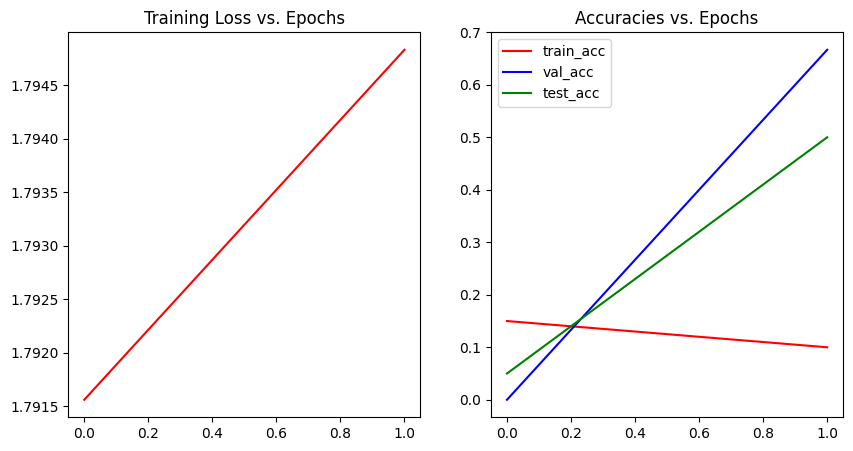

In [16]:
plot_history(train_cnn)

In [17]:
rp_ViT = RevenuePredictorViT(args, args_vit, freeze_vit=True)
rp_ViT = rp_ViT.to(device) # send model to GPU

Pretrained weights found and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.projection_head.0.weight', 'head.projection_head.0.bias', 'head.projection_head.2.weight', 'head.projection_head.2.bias', 'head.projection_head.4.weight', 'head.projection_head.4.bias', 'head.prototypes.weight'])
Pretrained weights found and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.projection_head.0.weight', 'head.projection_head.0.bias', 'head.projection_head.2.weight', 'head.projection_head.2.bias', 'head.projection_head.4.weight', 'head.projection_head.4.bias', 'head.prototypes.weight'])


In [18]:
train_vit = fit_one_cycle(rp_ViT, device, train_dl, val_dl, test_dl, torch.optim.Adam, train_args)

Epoch [0] : train_loss: 1.7905, train_acc: 0.2000, val_loss: 1.7815, val_acc: 0.6667, test_acc: 0.5000
Epoch [1] : train_loss: 1.7851, train_acc: 0.1500, val_loss: 1.7797, val_acc: 0.6667, test_acc: 0.5000


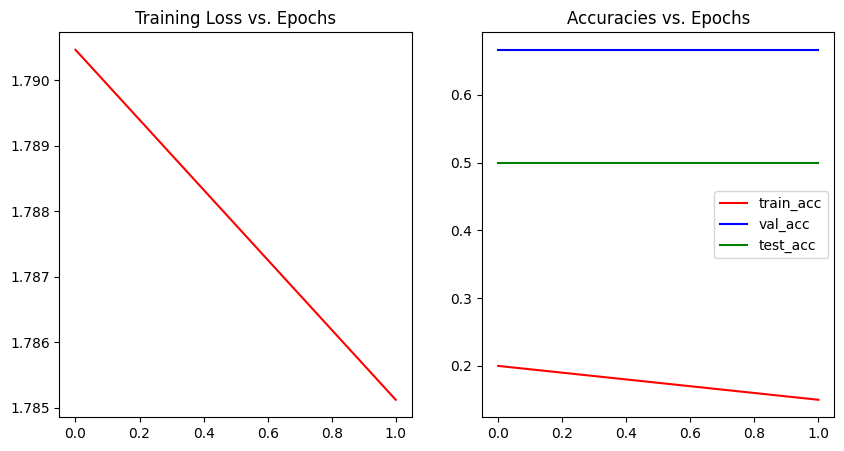

In [19]:
plot_history(train_vit)

# Visualize Attentions

In [20]:
def visualize_attention(model, args, img):

    for p in model.parameters():
        p.requires_grad = False
        
    w_featmap = img.shape[-2] // args['patch_size']
    h_featmap = img.shape[-1] // args['patch_size']

    attentions = model.get_last_selfattention(img.swapaxes(-1,-2).to(device))

    nh = attentions.shape[1] # number of head

    # we keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    if args['threshold'] is not None:
        # we keep only a certain percentage of the mass
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - args['threshold'])
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        # interpolate
        th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=args['patch_size'], mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    os.makedirs(args['output_dir'], exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args['output_dir'], "img.png"))
    for j in range(nh):
        fname = os.path.join(args['output_dir'], "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        print(f"{fname} saved.")
        plt.imshow(attentions[j])
        plt.show()

    if args['threshold'] is not None:
        image = skimage.io.imread(os.path.join(args['output_dir'], "img.png"))
        for j in range(nh):
            display_instances(image, th_attn[j], fname=os.path.join(args['output_dir'], "mask_th" + str(args['threshold']) + "_head" + str(j) +".png"), blur=False)

torch.Size([3, 256, 256])
torch.Size([24])
tensor([1., 0., 0., 0., 0., 0.])


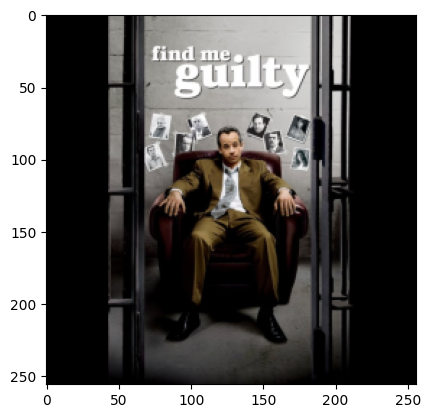

./attn-head0.png saved.


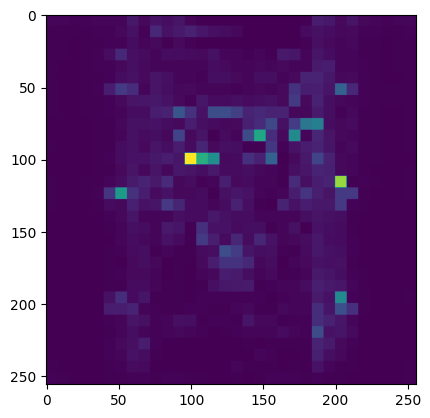

./attn-head1.png saved.


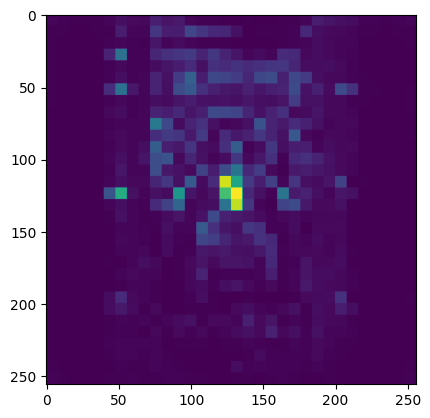

./attn-head2.png saved.


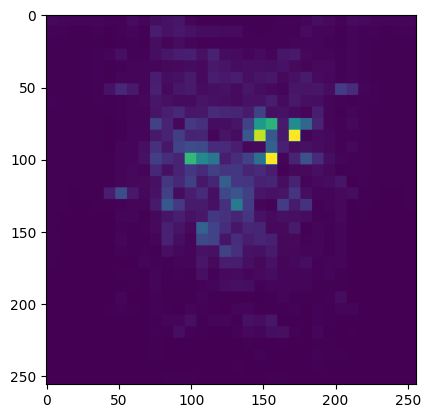

./attn-head3.png saved.


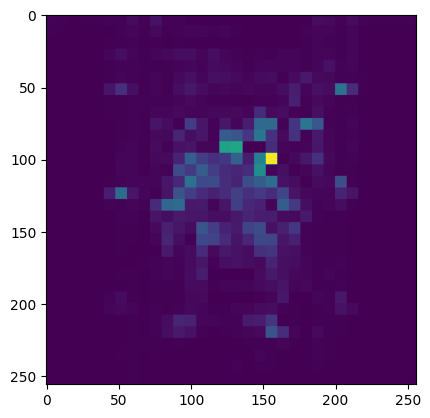

./attn-head4.png saved.


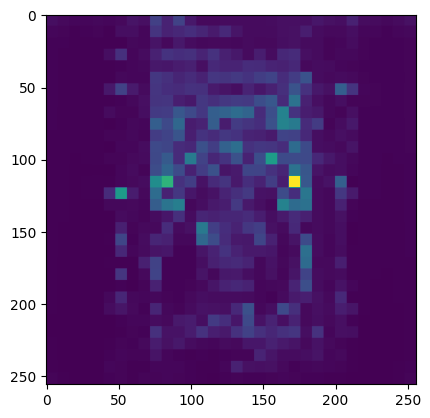

./attn-head5.png saved.


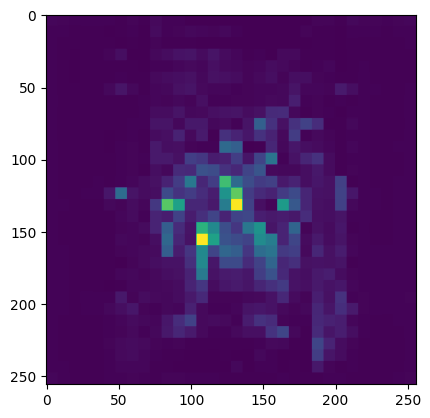

In [21]:
img, features, label = train_dataset[3]
print(img.shape)
print(features.shape)
print(label)
plt.imshow(img.swapaxes(0,2).detach().numpy())
plt.show()
img = img.unsqueeze(0).to(torch.float32)
features = features.unsqueeze(0)
visualize_attention(rp_ViT.vit_teacher, args_vit, img)